In [1]:
import pandas as pd
import glob
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import metapredict as meta
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
warnings.filterwarnings('ignore')
sns.set_context('talk')

/opt/anaconda3/envs/jupyter_env/lib/python3.10/site-packages/alphaPredict/backend/parrot_alpha.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  brnn_network.load_state_

- Using input generated in Zoonomia All TFs.ipynb http://localhost:8888/lab/workspaces/auto-8/tree/Desktop/Staller_Lab/SFARI/notebooks/Zoonomia%20All%20TFs.ipynb
- UPloaded to UCSC genome browser

In [2]:
verteb_phyloP  = []

verteb_outputs = glob.glob("../data/TF_all_cds_split/100_verteb_all_TFs_pt_*")

for v in verteb_outputs:
    # Read in 
    df = pd.read_csv(v, 
                 delim_whitespace=True, 
                 comment='#', 
                 header=None, 
                skiprows = 1,
                 names=['Position', 'Value'])
    df = df.reset_index()
    #Extract chromosome number
    df["chr"] = df["Position"].str.split("chr").str[-1]

    # update chromosome number
    most_recent_chr = ""
    for i in df.index:
        row = df.loc[i]
        if row["index"] == "variableStep":
            most_recent_chr = row["chr"]
        else:
            df.at[i, "chr"] = most_recent_chr
    df = df[df["index"] != "variableStep"].drop(columns = "Value")
    verteb_phyloP.append(df)

verteb_phyloP = pd.concat(verteb_phyloP)
verteb_phyloP = verteb_phyloP.reset_index(drop = True)
verteb_phyloP

,index,Position,chr
0,186081047,5.52444,3
1,186081048,2.08463,3
2,186081049,4.91019,3
3,186081050,7.73575,3
4,186081051,4.41879,3
...,...,...,...
2753371,3573344,1.14258,19
2753372,3573345,0.177819,19
2753373,3573346,0.623094,19
2753374,3573347,-0.0448189,19


In [3]:
verteb_phyloP["index"] = verteb_phyloP["index"].astype(int) - 1
verteb_phyloP["end"] = verteb_phyloP["index"].astype(int) + 1
verteb_phyloP["chr"] = "chr" + verteb_phyloP["chr"].astype(str)
verteb_phyloP = verteb_phyloP[["chr", "index", "end", "Position"]]
verteb_phyloP.columns = [0, 1, 2, 3]
verteb_phyloP

,0,1,2,3
0,chr3,186081046,186081047,5.52444
1,chr3,186081047,186081048,2.08463
2,chr3,186081048,186081049,4.91019
3,chr3,186081049,186081050,7.73575
4,chr3,186081050,186081051,4.41879
...,...,...,...,...
2753371,chr19,3573343,3573344,1.14258
2753372,chr19,3573344,3573345,0.177819
2753373,chr19,3573345,3573346,0.623094
2753374,chr19,3573346,3573347,-0.0448189


In [4]:
verteb_phyloP = verteb_phyloP.drop_duplicates()
verteb_phyloP = verteb_phyloP.reset_index(drop = True)
verteb_phyloP.columns = ["chr", "start", "end", "PhyloP"]
verteb_phyloP

,chr,start,end,PhyloP
0,chr3,186081046,186081047,5.52444
1,chr3,186081047,186081048,2.08463
2,chr3,186081048,186081049,4.91019
3,chr3,186081049,186081050,7.73575
4,chr3,186081050,186081051,4.41879
...,...,...,...,...
2751585,chr19,3573343,3573344,1.14258
2751586,chr19,3573344,3573345,0.177819
2751587,chr19,3573345,3573346,0.623094
2751588,chr19,3573346,3573347,-0.0448189


In [5]:
# Are there other header rows?
verteb_phyloP["chr"].value_counts()
# No, looks okay!

chr
chr19    579644
chr1     238896
chr2     156936
chr7     155876
chr16    145752
chr6     142881
chr12    131712
chr3     114207
chr9     110661
chr17    109135
chr20    101346
chr11     98928
chr8      92487
chr4      78102
chrX      72951
chr10     72510
chr5      68625
chr18     65862
chr15     62058
chr14     52164
chr13     34623
chr22     32814
chr21     28635
chrY       4785
Name: count, dtype: int64

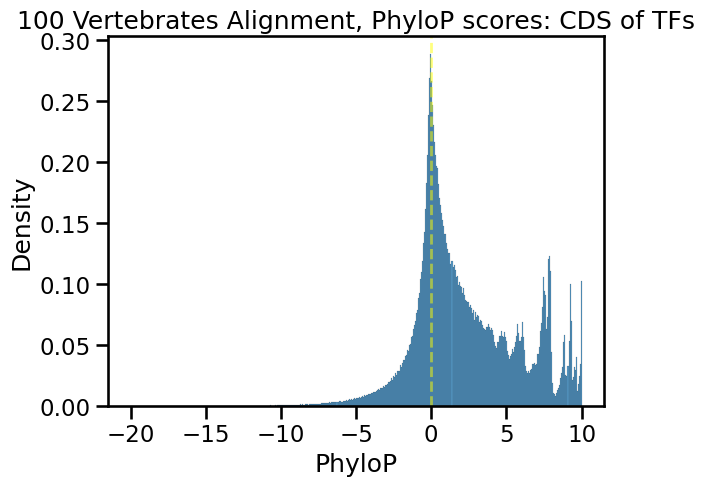

In [6]:
sns.histplot(verteb_phyloP["PhyloP"].astype(float), stat = "density")
plt.axvline(0, color = "yellow", lw = 2, ls = "--", alpha = 0.5)
plt.title("100 Vertebrates Alignment, PhyloP scores: CDS of TFs");

In [7]:
# Preparing for variant analysis script
verteb_phyloP["chr"] = verteb_phyloP["chr"].str[3:]
verteb_phyloP["start"] = verteb_phyloP["start"].astype(int)
verteb_phyloP["end"] = verteb_phyloP["end"].astype(int)
verteb_phyloP

,chr,start,end,PhyloP
0,3,186081046,186081047,5.52444
1,3,186081047,186081048,2.08463
2,3,186081048,186081049,4.91019
3,3,186081049,186081050,7.73575
4,3,186081050,186081051,4.41879
...,...,...,...,...
2751585,19,3573343,3573344,1.14258
2751586,19,3573344,3573345,0.177819
2751587,19,3573345,3573346,0.623094
2751588,19,3573346,3573347,-0.0448189


In [73]:
#verteb_phyloP.to_csv("../soto_analysis/raw_files/100_verteb_all_TF_cds.bed", sep = "\t", header = None, index = None)

In [10]:
ad_phylo_P = []

ENSTs = glob.glob("../soto_analysis/outputs/mutations/domains_100_verteb_all_TF_cds/*")
for ENST in ENSTs:
    df = pd.read_csv(ENST, sep = "\t", header = None)
    ad_phylo_P.append(df)

ad_phylo_P = pd.concat(ad_phylo_P)
ad_phylo_P = ad_phylo_P.rename(columns = {7: "ENST", 16: "PhyloP"})
dbd_phylo_P = ad_phylo_P[ad_phylo_P[3] == "DBD"]
ad_phylo_P = ad_phylo_P[ad_phylo_P[3] == "AD"]
ad_phylo_P

,0,1,2,3,4,5,6,ENST,8,9,10,11,12,13,14,15,PhyloP
414,6,53128617,53128618,AD,NaN,.,-,ENST00000259803,6,53128617,53128618,ENST00000259803,-1,6,53128617,53128618,-0.000039
415,6,53128618,53128619,AD,NaN,.,-,ENST00000259803,6,53128618,53128619,ENST00000259803,-1,6,53128618,53128619,0.464512
416,6,53128619,53128620,AD,NaN,.,-,ENST00000259803,6,53128619,53128620,ENST00000259803,-1,6,53128619,53128620,0.154811
417,6,53128620,53128621,AD,NaN,.,-,ENST00000259803,6,53128620,53128621,ENST00000259803,-1,6,53128620,53128621,0.077386
418,6,53128621,53128622,AD,NaN,.,-,ENST00000259803,6,53128621,53128622,ENST00000259803,-1,6,53128621,53128622,2.632420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,19,15379724,15379725,AD,NaN,.,-,ENST00000269701,19,15379724,15379725,ENST00000269701,-1,19,15379724,15379725,2.466830
2312,19,15379725,15379726,AD,NaN,.,-,ENST00000269701,19,15379725,15379726,ENST00000269701,-1,19,15379725,15379726,-0.431197
2313,19,15379726,15379727,AD,NaN,.,-,ENST00000269701,19,15379726,15379727,ENST00000269701,-1,19,15379726,15379727,2.350910
2314,19,15379727,15379728,AD,NaN,.,-,ENST00000269701,19,15379727,15379728,ENST00000269701,-1,19,15379727,15379728,2.350910


In [11]:
dbd_phylo_P

,0,1,2,3,4,5,6,ENST,8,9,10,11,12,13,14,15,PhyloP
0,6,53130872,53130873,DBD,NaN,.,-,ENST00000259803,6,53130872,53130873,ENST00000259803,-1,6,53130872,53130873,4.83989
1,6,53130873,53130874,DBD,NaN,.,-,ENST00000259803,6,53130873,53130874,ENST00000259803,-1,6,53130873,53130874,1.92887
2,6,53130874,53130875,DBD,NaN,.,-,ENST00000259803,6,53130874,53130875,ENST00000259803,-1,6,53130874,53130875,1.46310
3,6,53130875,53130876,DBD,NaN,.,-,ENST00000259803,6,53130875,53130876,ENST00000259803,-1,6,53130875,53130876,6.70294
4,6,53130876,53130877,DBD,NaN,.,-,ENST00000259803,6,53130876,53130877,ENST00000259803,-1,6,53130876,53130877,4.02480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,19,15379727,15379728,DBD,NaN,.,-,ENST00000269701,19,15379727,15379728,ENST00000269701,-1,19,15379727,15379728,2.35091
2072,19,15379728,15379729,DBD,NaN,.,-,ENST00000269701,19,15379728,15379729,ENST00000269701,-1,19,15379728,15379729,3.74197
2073,19,15379729,15379730,DBD,NaN,.,-,ENST00000269701,19,15379729,15379730,ENST00000269701,-1,19,15379729,15379730,2.93052
2074,19,15379730,15379731,DBD,NaN,.,-,ENST00000269701,19,15379730,15379731,ENST00000269701,-1,19,15379730,15379731,3.85789


In [33]:
cds_phylo_P = []

cds_paths = glob.glob("../soto_analysis/outputs/mutations/cds_100_verteb_all_TF_cds/*")

for path in cds_paths:
    ENST = path.split("/")[-1].split(".bed")[0]
    if ENST in set(ad_phylo_P["ENST"]):
        df = pd.read_csv(path, sep = "\t", header = None)
        cds_phylo_P.append(df)

cds_phylo_P = pd.concat(cds_phylo_P)
cds_phylo_P = cds_phylo_P.rename(columns = {3: "ENST", 8: "PhyloP"})
cds_phylo_P

,0,1,2,ENST,4,5,6,7,PhyloP
0,6,53128206,53128207,ENST00000259803,-1,6,53128206,53128207,1.030160
1,6,53128207,53128208,ENST00000259803,-1,6,53128207,53128208,3.733460
2,6,53128208,53128209,ENST00000259803,-1,6,53128208,53128209,0.309276
3,6,53128209,53128210,ENST00000259803,-1,6,53128209,53128210,2.021370
4,6,53128210,53128211,ENST00000259803,-1,6,53128210,53128211,0.309276
...,...,...,...,...,...,...,...,...,...
2074,19,15379727,15379728,ENST00000269701,-1,19,15379727,15379728,2.350910
2075,19,15379728,15379729,ENST00000269701,-1,19,15379728,15379729,3.741970
2076,19,15379729,15379730,ENST00000269701,-1,19,15379729,15379730,2.930520
2077,19,15379730,15379731,ENST00000269701,-1,19,15379730,15379731,3.857890


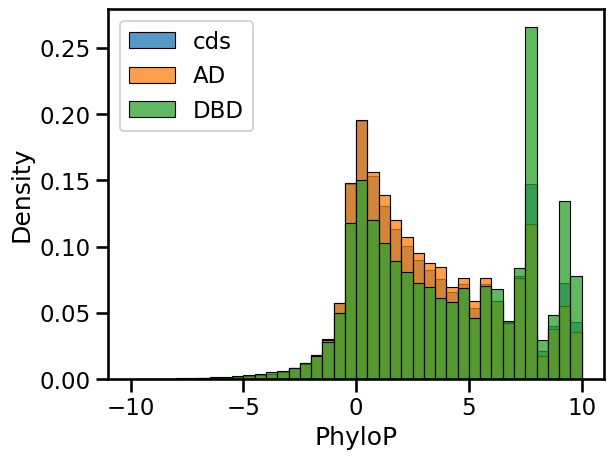

In [34]:
bins = np.arange(-10, 10.1, 0.5)
sns.histplot(cds_phylo_P["PhyloP"], label = "cds", stat = "density", bins = bins)
sns.histplot(ad_phylo_P["PhyloP"], label = "AD", stat = "density", bins = bins)
sns.histplot(dbd_phylo_P["PhyloP"], label = "DBD", stat = "density", bins = bins)
plt.legend();

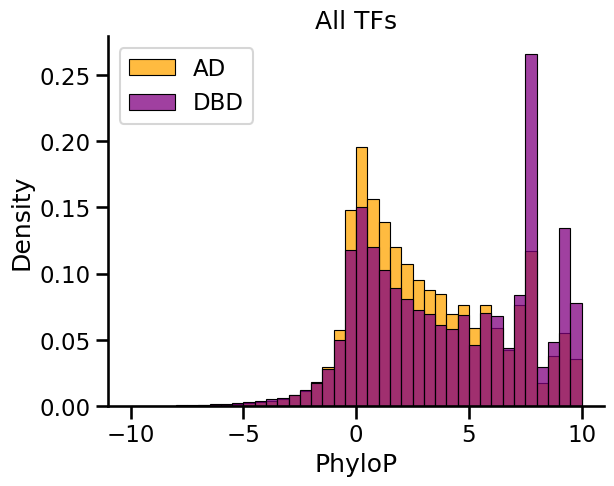

In [35]:
bins = np.arange(-10, 10.1, 0.5)
#sns.histplot(data = df_cds_no_ad, x = "PhyloP_x", bins = bins, stat = "density")
sns.histplot(data = ad_phylo_P, x = "PhyloP", bins = bins, stat = "density", color = "orange", label = "AD")
sns.histplot(data = dbd_phylo_P, x = "PhyloP", bins = bins, stat = "density", color = "purple", label = "DBD")
plt.title("All TFs")
plt.legend()
sns.despine();

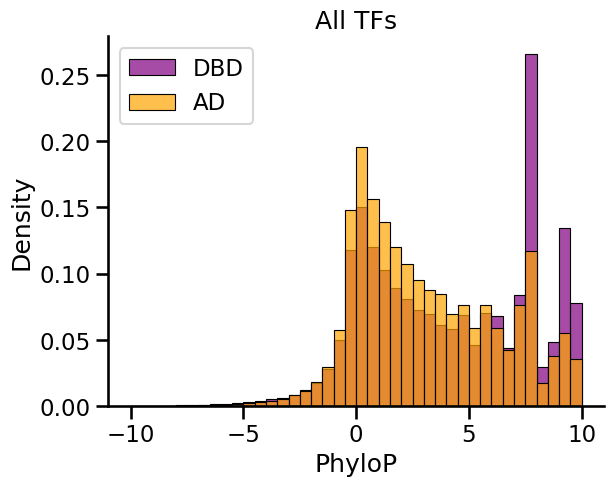

In [36]:
bins = np.arange(-10, 10.1, 0.5)
#sns.histplot(data = df_cds_no_ad, x = "PhyloP_x", bins = bins, stat = "density")
sns.histplot(data = dbd_phylo_P, x = "PhyloP", bins = bins, stat = "density", color = "purple", label = "DBD", alpha = 0.7)
sns.histplot(data = ad_phylo_P, x = "PhyloP", bins = bins, stat = "density", color = "orange", label = "AD", alpha = 0.7)
plt.title("All TFs")
plt.legend()
sns.despine();

In [37]:
def plot_mean(data, color, lw = 2):
    plt.axvline(data["PhyloP"].median(), color=color, ls='--', lw=lw)

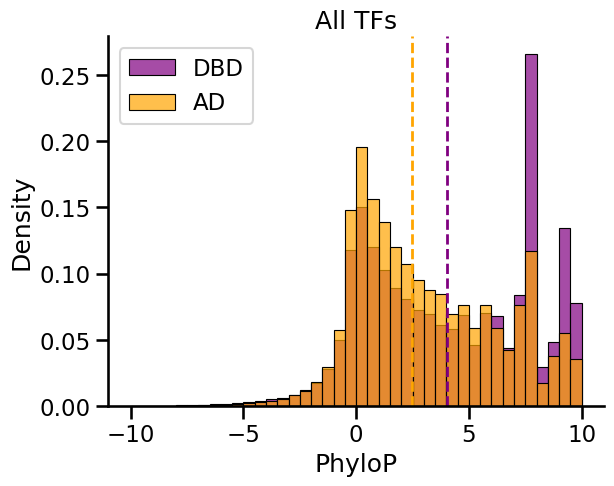

In [38]:
sns.set_context('talk')

bins = np.arange(-10, 10.1, 0.5)
#sns.histplot(data = df_cds_no_ad, x = "PhyloP_x", bins = bins, stat = "density")
sns.histplot(data = dbd_phylo_P, x = "PhyloP", bins = bins, stat = "density", color = "purple", label = "DBD", alpha = 0.7)
plot_mean(dbd_phylo_P, 'purple')

sns.histplot(data = ad_phylo_P, x = "PhyloP", bins = bins, stat = "density", color = "orange", label = "AD", alpha = 0.7)
plot_mean(ad_phylo_P, 'orange')

plt.title("All TFs")
plt.legend()
sns.despine();

In [39]:
cds_phylo_P_to_merge = cds_phylo_P[[0, 1, 2,"ENST", 4, "PhyloP"]].copy(deep = True)
cds_phylo_P_to_merge = cds_phylo_P_to_merge.rename(columns = {4: 12})
cds_phylo_P_to_merge

,0,1,2,ENST,12,PhyloP
0,6,53128206,53128207,ENST00000259803,-1,1.030160
1,6,53128207,53128208,ENST00000259803,-1,3.733460
2,6,53128208,53128209,ENST00000259803,-1,0.309276
3,6,53128209,53128210,ENST00000259803,-1,2.021370
4,6,53128210,53128211,ENST00000259803,-1,0.309276
...,...,...,...,...,...,...
2074,19,15379727,15379728,ENST00000269701,-1,2.350910
2075,19,15379728,15379729,ENST00000269701,-1,3.741970
2076,19,15379729,15379730,ENST00000269701,-1,2.930520
2077,19,15379730,15379731,ENST00000269701,-1,3.857890


In [40]:
ad_phylo_P_to_merge = ad_phylo_P[[0, 1, 2, "ENST", 12, "PhyloP"]]
ad_phylo_P_to_merge

,0,1,2,ENST,12,PhyloP
414,6,53128617,53128618,ENST00000259803,-1,-0.000039
415,6,53128618,53128619,ENST00000259803,-1,0.464512
416,6,53128619,53128620,ENST00000259803,-1,0.154811
417,6,53128620,53128621,ENST00000259803,-1,0.077386
418,6,53128621,53128622,ENST00000259803,-1,2.632420
...,...,...,...,...,...,...
2311,19,15379724,15379725,ENST00000269701,-1,2.466830
2312,19,15379725,15379726,ENST00000269701,-1,-0.431197
2313,19,15379726,15379727,ENST00000269701,-1,2.350910
2314,19,15379727,15379728,ENST00000269701,-1,2.350910


In [41]:
dbd_phylo_P_to_merge = dbd_phylo_P[[0, 1, 2, "ENST", 12, "PhyloP"]]
dbd_phylo_P_to_merge

,0,1,2,ENST,12,PhyloP
0,6,53130872,53130873,ENST00000259803,-1,4.83989
1,6,53130873,53130874,ENST00000259803,-1,1.92887
2,6,53130874,53130875,ENST00000259803,-1,1.46310
3,6,53130875,53130876,ENST00000259803,-1,6.70294
4,6,53130876,53130877,ENST00000259803,-1,4.02480
...,...,...,...,...,...,...
2071,19,15379727,15379728,ENST00000269701,-1,2.35091
2072,19,15379728,15379729,ENST00000269701,-1,3.74197
2073,19,15379729,15379730,ENST00000269701,-1,2.93052
2074,19,15379730,15379731,ENST00000269701,-1,3.85789


In [42]:
cds_phylo_P_to_merge = pd.merge(cds_phylo_P_to_merge, ad_phylo_P_to_merge, how = "left", indicator = "AD")
cds_phylo_P_to_merge = pd.merge(cds_phylo_P_to_merge, dbd_phylo_P_to_merge, how = "left", indicator = "DBD")
cds_phylo_P_to_merge

,0,1,2,ENST,12,PhyloP,AD,DBD
0,6,53128206,53128207,ENST00000259803,-1,1.030160,left_only,left_only
1,6,53128207,53128208,ENST00000259803,-1,3.733460,left_only,left_only
2,6,53128208,53128209,ENST00000259803,-1,0.309276,left_only,left_only
3,6,53128209,53128210,ENST00000259803,-1,2.021370,both,left_only
4,6,53128210,53128211,ENST00000259803,-1,0.309276,both,left_only
...,...,...,...,...,...,...,...,...
745444,19,15379727,15379728,ENST00000269701,-1,2.350910,both,both
745445,19,15379728,15379729,ENST00000269701,-1,3.741970,both,both
745446,19,15379729,15379730,ENST00000269701,-1,2.930520,left_only,both
745447,19,15379730,15379731,ENST00000269701,-1,3.857890,left_only,both


In [43]:
bool_dict = {"left_only" : False, "both" : True}

cds_phylo_P_to_merge["AD"] = cds_phylo_P_to_merge["AD"].map(bool_dict)
cds_phylo_P_to_merge["DBD"] = cds_phylo_P_to_merge["DBD"].map(bool_dict)
cds_phylo_P_to_merge

,0,1,2,ENST,12,PhyloP,AD,DBD
0,6,53128206,53128207,ENST00000259803,-1,1.030160,False,False
1,6,53128207,53128208,ENST00000259803,-1,3.733460,False,False
2,6,53128208,53128209,ENST00000259803,-1,0.309276,False,False
3,6,53128209,53128210,ENST00000259803,-1,2.021370,True,False
4,6,53128210,53128211,ENST00000259803,-1,0.309276,True,False
...,...,...,...,...,...,...,...,...
745444,19,15379727,15379728,ENST00000269701,-1,2.350910,True,True
745445,19,15379728,15379729,ENST00000269701,-1,3.741970,True,True
745446,19,15379729,15379730,ENST00000269701,-1,2.930520,False,True
745447,19,15379730,15379731,ENST00000269701,-1,3.857890,False,True


In [44]:
cds_phylo_P_to_merge_no_dom = cds_phylo_P_to_merge[(cds_phylo_P_to_merge["AD"] == False) & (cds_phylo_P_to_merge["DBD"] == False)]
cds_phylo_P_to_merge_no_dom

,0,1,2,ENST,12,PhyloP,AD,DBD
0,6,53128206,53128207,ENST00000259803,-1,1.030160,False,False
1,6,53128207,53128208,ENST00000259803,-1,3.733460,False,False
2,6,53128208,53128209,ENST00000259803,-1,0.309276,False,False
408,6,53128614,53128615,ENST00000259803,-1,0.541937,False,False
409,6,53128615,53128616,ENST00000259803,-1,-1.006570,False,False
...,...,...,...,...,...,...,...,...
742720,14,64268797,64268798,ENST00000341099,-1,3.022990,False,False
742721,14,64268798,64268799,ENST00000341099,-1,1.235390,False,False
743370,19,15354915,15354916,ENST00000269701,-1,0.034819,False,False
743371,19,15354916,15354917,ENST00000269701,-1,1.445620,False,False


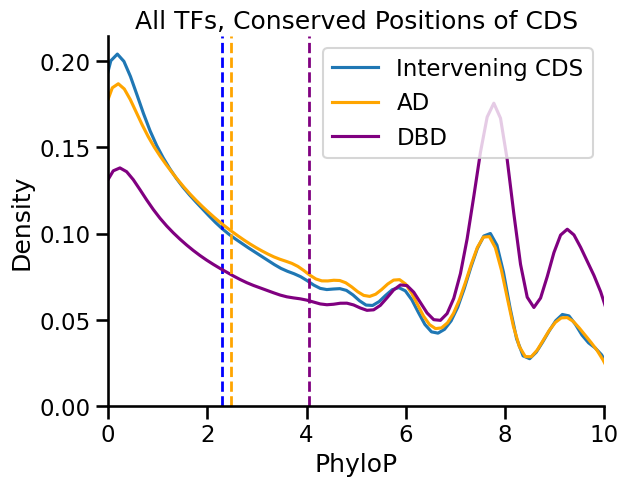

In [45]:
bins = np.arange(-10, 10.1, 0.5)
sns.kdeplot(data = cds_phylo_P_to_merge_no_dom, x = "PhyloP", label = "Intervening CDS")
plot_mean(cds_phylo_P_to_merge_no_dom, "b", lw = 2)

sns.kdeplot(data = ad_phylo_P, x = "PhyloP", color = "orange", label = "AD")
plot_mean(dbd_phylo_P, 'purple', lw = 2)

sns.kdeplot(data = dbd_phylo_P, x = "PhyloP", color = "purple", label = "DBD")
plot_mean(ad_phylo_P, 'orange', lw = 2)

plt.title("All TFs, Conserved Positions of CDS")
plt.legend()
plt.xlim(0, 10)
sns.despine();

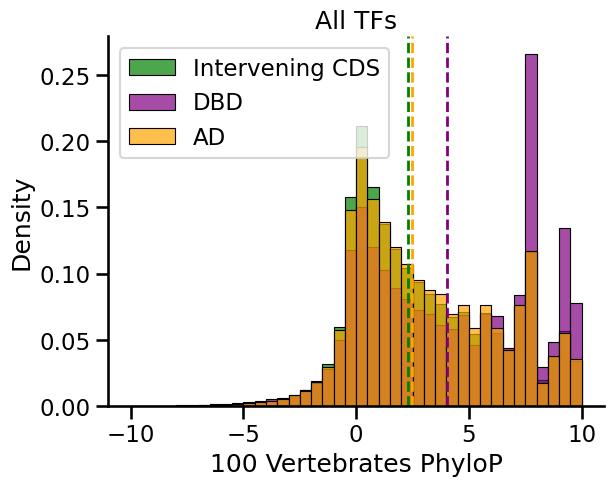

In [46]:
sns.set_context('talk')

bins = np.arange(-10, 10.1, 0.5)

sns.histplot(data = cds_phylo_P_to_merge_no_dom, x = "PhyloP", bins = bins, stat = "density", color = "green", label = "Intervening CDS", alpha = 0.7)
plot_mean(cds_phylo_P_to_merge_no_dom, 'green')

#sns.histplot(data = df_cds_no_ad, x = "PhyloP_x", bins = bins, stat = "density")
sns.histplot(data = dbd_phylo_P, x = "PhyloP", bins = bins, stat = "density", color = "purple", label = "DBD", alpha = 0.7)
plot_mean(dbd_phylo_P, 'purple')

sns.histplot(data = ad_phylo_P, x = "PhyloP", bins = bins, stat = "density", color = "orange", label = "AD", alpha = 0.7)
plot_mean(ad_phylo_P, 'orange')


plt.title("All TFs")
plt.xlabel("100 Vertebrates PhyloP")
plt.legend()
sns.despine();

In [47]:
lambert_TFs_ENST = pd.read_csv("../output/TFs_with_ENST.csv")
known_ADs = pd.read_csv("../output/known_ADs_considering_isoforms_and_canonical.csv")
ENST_to_gene_df = pd.merge(known_ADs, lambert_TFs_ENST, on = "uniprotID")[["ENST", "Gene"]].drop_duplicates()
ENST_to_gene_df["ENST"] = ENST_to_gene_df["ENST"].str.split('.').str[0]
ENST_to_gene = dict(zip(ENST_to_gene_df["ENST"], ENST_to_gene_df["Gene"]))
lambert_TFs = pd.read_csv("../output/lambert_TFs_10-21-24_with_DBD_coords.csv")
lambert_TFs["uniprotID"] = lambert_TFs["id"].str.split("|").str[1]
lambert_TFs = pd.merge(lambert_TFs, lambert_TFs_ENST, on = "uniprotID")
lambert_TFs["ENST"] = lambert_TFs["ENST"].str.split('.').str[0]
lambert_TFs

,Unnamed: 0_x,id,ProteinSeq,DBD_coords_merged,uniprotID,Unnamed: 0_y,ENST,canonical_uniprot_id_isoform
0,0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[[221, 243], [249, 271], [277, 299], [305, 327...",A0A087WUV0,0,ENST00000425953,A0A087WUV0
1,1,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,MENEKENLFCEPHKRGLMKTPLKESTTANIVLAEIQPDFGPLTTPT...,"[[114, 182], [262, 347]]",A0AVK6,1,ENST00000250024,A0AVK6
2,2,sp|A0PJY2|FEZF1_HUMAN Fez family zinc finger p...,MDSSCHNATTKMLATAPARGNMMSTSKPLAFSIERIMARTPEPKAL...,"[[260, 282], [288, 310], [316, 338], [344, 366...",A0PJY2,747,ENST00000442488,A0PJY2-1
3,3,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,MKRRQKRKHLENEESQETAEKGGGMSKSQEDALQPGSTRVAKGWSQ...,"[[1, 330]]",A1A519,748,ENST00000695508,A1A519-1
4,4,sp|A1YPR0|ZBT7C_HUMAN Zinc finger and BTB doma...,MANDIDELIGIPFPNHSSEVLCSLNEQRHDGLLCDVLLVVQEQEYR...,"[[364, 386], [392, 414], [420, 442], [448, 469]]",A1YPR0,2,ENST00000535628,A1YPR0
...,...,...,...,...,...,...,...,...
1585,1608,sp|Q9Y6Q9|NCOA3_HUMAN Nuclear receptor coactiv...,MSGLGENLDPLASDSRKRKLPCDTPGQGLTCSGEKRRREQESKYIE...,"[[31, 83]]",Q9Y6Q9,2129,ENST00000371998,Q9Y6Q9-1
1586,1609,sp|Q9Y6R6|Z780B_HUMAN Zinc finger protein 780B...,MVHGSVTFRDVAIDFSQEEWECLQPDQRTLYRDVMLENYSHLISLG...,"[[165, 187], [193, 215], [221, 243], [249, 271...",Q9Y6R6,745,ENST00000434248,Q9Y6R6
1587,1610,sp|Q9Y6X0|SETBP_HUMAN SET-binding protein OS=H...,MESRETLSSSRQRGGESDFLPVSSAKPPAAPGCAGEPLLSTPGPGK...,"[[583, 596], [1015, 1027], [1450, 1462]]",Q9Y6X0,2130,ENST00000649279,Q9Y6X0-1
1588,1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,"[[78, 101], [110, 133], [271, 317], [442, 496]...",Q9Y6X8,746,ENST00000314393,Q9Y6X8



ENST00000287820
PPARG


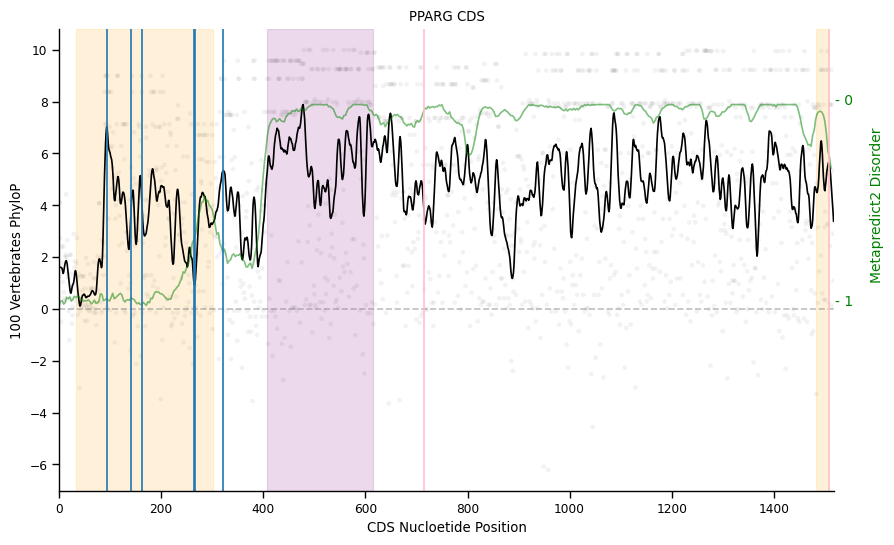

In [100]:
sns.set_context('paper')

tfs_tbl = pd.read_csv("../soto_analysis/outputs/all_TFs_table_proteins.txt", sep = "\t")


#https://www.geeksforgeeks.org/python-make-a-list-of-intervals-with-sequential-numbers/
def intervals_extract(iterable):
     
    iterable = sorted(set(iterable))
    for key, group in itertools.groupby(enumerate(iterable),
    lambda t: t[1] - t[0]):
        group = list(group)
        yield [group[0][1], group[-1][1]]

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

for ENST in set(cds_phylo_P["ENST"]) & set(tfs_tbl["ENST"]):

#for ENST in ["ENST00000287820"]:
    print()
    print(ENST)
    #display(tfs_tbl[tfs_tbl["ENST"] == ENST])
    ENST_phylo_P = cds_phylo_P[cds_phylo_P["ENST"] == ENST]
    # If negative strand, sort ascending = False
    # Else, sort ascending = True

    #print(ENST_phylo_P[4].iloc[0])
    #print(type(ENST_phylo_P[4].iloc[0]))
    
    if ENST_phylo_P[4].iloc[0] == -1:
        ascending = False
    else: 
        #print("pos")
        ascending = True
        
    ENST_phylo_P = ENST_phylo_P.sort_values(by = 1, ascending = ascending)
    #display(ENST_phylo_P)
    
    uniprotID = lambert_TFs[lambert_TFs["ENST"] == ENST]["uniprotID"].iloc[0]
    domains = pd.read_csv("../soto_analysis/outputs/mutations/domains_zoonomia_all_TF_cds/" + ENST + ".bed", sep = "\t", header = None)
    domains = domains[[0, 1, 2, 3]]
    #display(domains)
    #ENST_phylo_P_with_domains = pd.merge(ENST_phylo_P, domains, how = "left", on = [0, 1, 2])
    #ENST_phylo_P_with_domains = ENST_phylo_P_with_domains.fillna(0)
    #ENST_phylo_P_with_domains = ENST_phylo_P_with_domains.drop_duplicates().reset_index(drop = True)
    ENST_phylo_P["cds_nt"] = np.arange(len(ENST_phylo_P))
    #display(ENST_phylo_P_with_domains)
    #display(ENST_phylo_P_with_domains)
   # display(ENST_phylo_P)


    # Apply lowess smoothing
    gene = ENST_to_gene[ENST]
    
    smoothed = lowess(ENST_phylo_P['PhyloP'], ENST_phylo_P["cds_nt"], frac=0.01)  # Adjust frac for smoothness
    color_map = {
        'AD': 'orange',
        'DBD': 'purple'
    }
    
    # Create a new DataFrame for smoothed data
    smoothed_df = pd.DataFrame(smoothed, columns=["cds_nt", 'smoothed'])
    
    # Plot
    plt.figure(figsize=(10, 6))
    
    # Create background color blocks based on '3_y'
    for value, color in color_map.items():
        domains_subset = domains[domains[3] == value]
        #display(domains_subset)
        
        ENST_phylo_P_with_domains = pd.merge(ENST_phylo_P, domains_subset, how = "left", on = [0, 1, 2])
        #ENST_phylo_P_with_domains = ENST_phylo_P_with_domains.fillna(0)
        ENST_phylo_P_with_domains = ENST_phylo_P_with_domains.drop_duplicates().reset_index(drop = True)
        ENST_phylo_P_with_domains["cds_nt"] = np.arange(len(ENST_phylo_P_with_domains))
        subset = ENST_phylo_P_with_domains[ENST_phylo_P_with_domains[3] == value]
        #display(subset)
        subset = subset.sort_values(by = "cds_nt")
        intervals = list(intervals_extract(subset["cds_nt"]))

            
        expected = known_ADs[known_ADs["uniprotID"] == uniprotID]

                    
        for interval in intervals:
            if value == "AD":
                if (int((interval[0] + 2)/ 3) + 1 not in set(expected["Start"])):
                    print("MISMATCH")
                    print(int((interval[0] + 3)/ 3) + 1)
                    print(int((interval[1] + 3)/ 3) + 1)
                    display(expected)
            plt.axvspan(interval[0], interval[1], color=color, alpha=0.15)

        # print(intervals)
        # display(expected)

        
    sns.scatterplot(data=ENST_phylo_P_with_domains, x="cds_nt", y='PhyloP', color='black', alpha = 0.05, size = 20, legend = False)
    #plt.legend().remove()
    sns.lineplot(data=smoothed_df, x="cds_nt", y='smoothed', color='black')
    sns.despine()
    plt.xlim(0, max(smoothed_df["cds_nt"]) + 1)
    #extreme = max(np.abs(ENST_phylo_P_with_domains["PhyloP"]))
    #plt.ylim(-1 * extreme - 0.1, extreme + 0.1)

    #uniprotID = cc_names[cc_names["ENST"] == ENST]["uniprotID"].iloc[0]
    TF_seq = lambert_TFs[lambert_TFs["ENST"] == ENST]["ProteinSeq"].iloc[0]
    disorder = np.array(meta.predict_disorder(TF_seq))


    plt.axhline(0, color = "gray", linestyle = "--", alpha = 0.5)
    plt.ylabel("100 Vertebrates PhyloP", color = "black")
    plt.xlabel('CDS Nucloetide Position')  

    #ax2 = plt.twinx()

    # Normalizing to smoothed
    
    normalized = (disorder - np.mean(disorder)) / np.std(disorder)
    #normalized_to_phyloP = 

    phyloP_min, phyloP_max = min(smoothed_df["smoothed"]), max(smoothed_df["smoothed"])
    inverse_disorder_scaled = (np.array(1 - disorder) * (phyloP_max - phyloP_min)) + phyloP_min
    sns.lineplot(x = np.arange(0, len(disorder) * 3, 3), y = inverse_disorder_scaled, color = "green", alpha = 0.5)

    inv_dis_scal_0 = (0 * (phyloP_max - phyloP_min)) + phyloP_min
    inv_dis_scal_1 = (1 * (phyloP_max - phyloP_min)) + phyloP_min

    plt.text(len(disorder) * 3 + 5, inv_dis_scal_0,'- 1', fontsize=10, color = "green")
    plt.text(len(disorder) * 3 + 5, inv_dis_scal_1,'- 0', fontsize=10, color = "green")
    plt.text(len(disorder) * 3 + 10, (inv_dis_scal_0 + inv_dis_scal_1) / 2,'\n\nMetapredict2 Disorder', verticalalignment = "center", fontsize=10, color = "green", rotation = 90)

    #plt.text(len(disorder) * 3 + 5, np.mean(inv_dis_scal_0, inv_dis_scal_1),'- 0', fontsize=10, color = "green")

    #plt.ylabel("1 - Metapredict2", color = "green")
    #plt.ylim(-1.1, 1.1)

    #plt.ylim(0, 10)
    # Add labels and legend
    #print(ENST)
    plt.title(gene + ' CDS')
    # plt.ylabel('PhyloP Score')
    #plt.legend(title='Domain Type')
    gene = gene.replace("/", "-").replace(".","").strip()
    print(gene)

    #PPARG annotations
    # positions = [31, 47, 54, 88, 89, 107]
    # for pos in positions:
    #     plt.axvline(pos * 3)
    
    # plt.axvline(238 * 3, color = "pink")
    # plt.axvline(503 * 3, color = "pink")

    plt.savefig("../output/100_vertebrates_PhyloP_traces/metapredict/" + gene);
